## Import Libraries

In [134]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [135]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [136]:
df.shape

(5624, 11)

In [137]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [138]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [139]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [140]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [141]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [142]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

In [143]:
df = df[df['Year']>=2000]

In [144]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [145]:
df.shape

(5364, 11)

In [146]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [147]:
df.shape

(5364, 11)

In [148]:
#df[df['Type']=='Other']

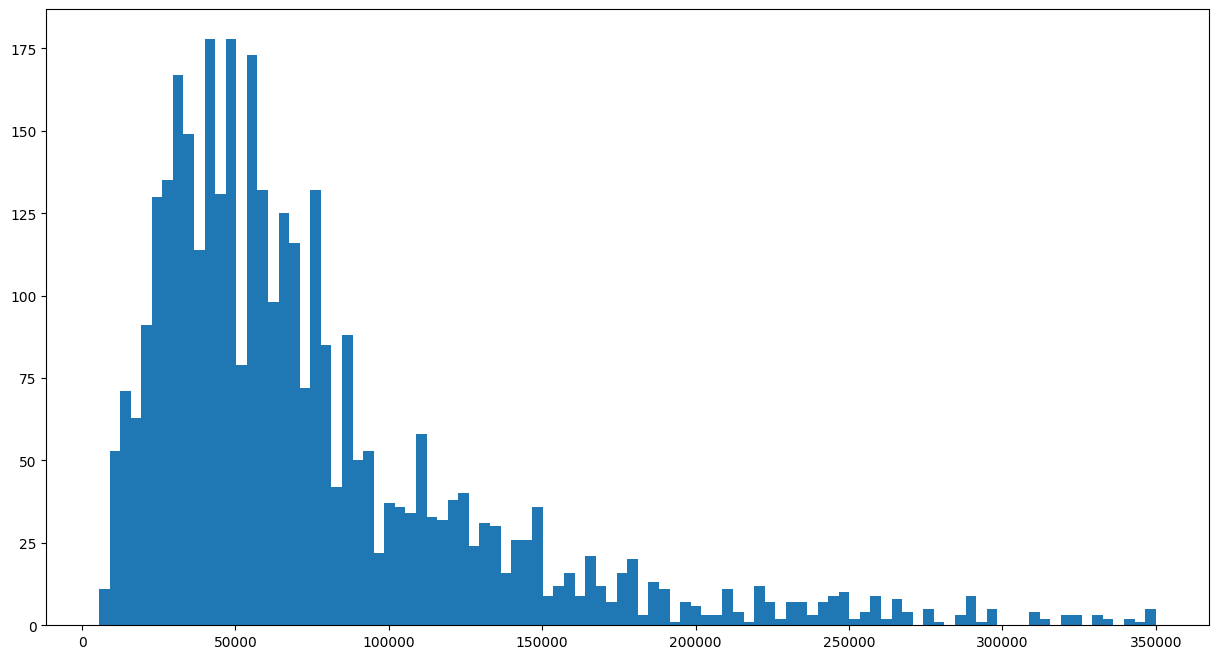

In [149]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [150]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [151]:
df.shape

(3566, 11)

In [152]:
#df[df['Mileage']<1000]

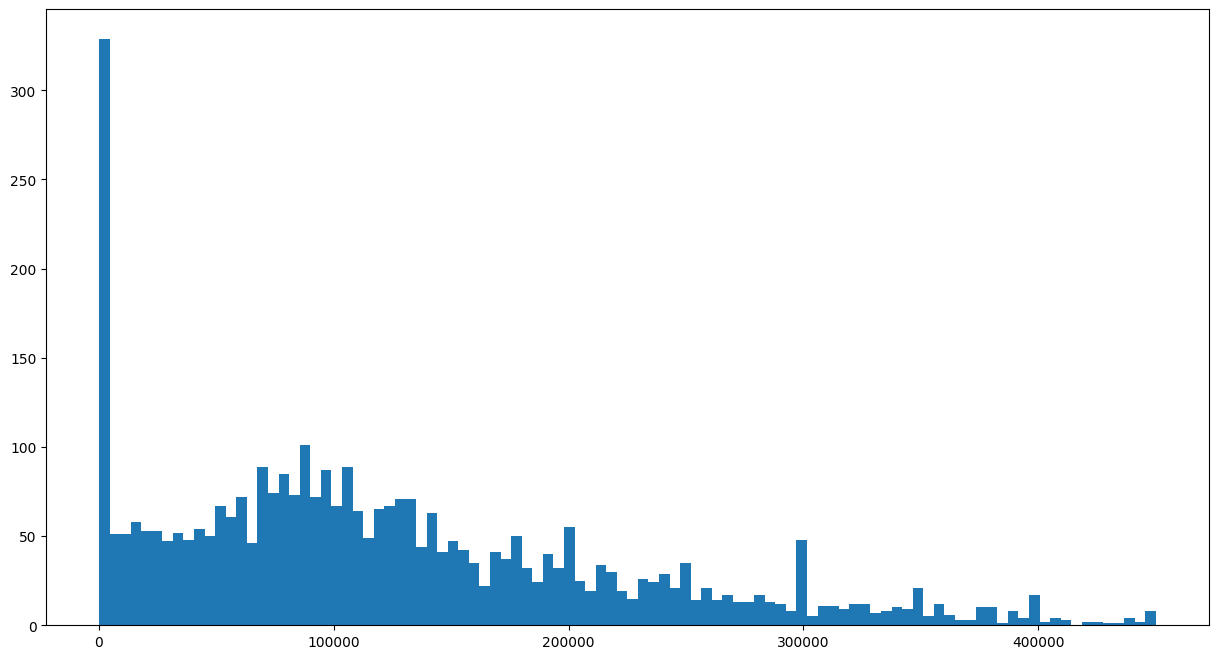

In [153]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [154]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [155]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [156]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [157]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [158]:
df.shape

(3511, 325)

In [159]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


In [160]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['Price'].quantile(0.35)
p75 = df['Price'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['car_price_category'] = df['Price'].apply(categorize_price)


# Verify the distribution of the new categories
print(df['car_price_category'].value_counts())

car_price_category
Good_Price     1404
Cheap_Price    1227
High_Price      880
Name: count, dtype: int64


#### 3. Feature selection

In [161]:
# sns.heatmap(df.corr(), annot=True);

In [129]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

ValueError: could not convert string to float: 'High_Price'

In [162]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Type_Range Rover', 'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
       'Make_Mercedes', 'Options_Full', 'Options_Standard'],
      dtype='object')

In [163]:
selected_features = ['Year', 'Engine_Size', 'Mileage',
                     'car_price_category', 
                     'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
                     'Make_Mercedes', 'Origin_Gulf Arabic', 'Options_Full',
                     'Options_Standard']

In [164]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,car_price_category,Make_Hyundai,Make_Land Rover,Make_Lexus,Make_Mercedes,Origin_Gulf Arabic,Options_Full,Options_Standard
1,2014,8.0,80000,High_Price,False,False,False,False,False,True,False
2,2015,5.0,140000,High_Price,False,True,False,False,True,True,False
3,2015,2.4,220000,Cheap_Price,False,False,False,False,False,False,False
5,2019,2.0,25000,Good_Price,False,False,False,False,False,False,False
6,2012,4.8,189000,Good_Price,False,False,False,False,False,True,False


#### 4. Prepare train and test data

In [167]:
# Prepare data
X = df.drop(['car_price_category'], axis=1)
y = df['car_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [168]:
X.shape

(3511, 10)

## Buliding the Model

In [170]:
model = LogisticRegression()

## Train the Model

In [171]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [172]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [173]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

ValueError: Shape of passed values is (3, 10), indices imply (10, 1)

In [175]:
print(model.intercept_) 

[ 0.08397632  0.98150546 -1.06548177]


## Evaluating the Model 

In [181]:
# our benchmark model
base_model = round((df['car_price_category'].value_counts()[0] / df.shape[0])*100,2)
base_model

39.99

1. Accuracy

In [184]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7254623044096729

In [185]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[179,  61,   3],
       [ 54, 191,  35],
       [  1,  39, 140]])